In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from DVFSController import DVFSController

In [2]:
def load_json(filepath):
	with open(filepath, 'r') as file:
		data = json.load(file)
	
	return data

## Preprocessing

In [ ]:
FPS_OD_TRACE_PATH = '../dataset/fps-od-trace.json'
FPS_P_TRACE_PATH = '../dataset/fps-p-trace.json'
TPS_TRACE_PATH = '../dataset/tps-trace.json'

FPS_OD_PERFORMANCE_PATH = '../result/final/yolov8-640.json'
FPS_P_PERFORMANCE_PATH = '../result/final/gemma-3-4B-prefill.json'
TPS_PERFORMANCE_PATH = '../result/final/gemma-3-4B-decode.json'

FPS_OD_PERFORMANCE_DEFAULT_PATH = '../result/final/yolov8-640-default.json'
FPS_P_PERFORMANCE_DEFAULT_PATH = '../result/final/gemma-3-4B-prefill-default.json'
TPS_PERFORMANCE_DEFAULT_PATH = '../result/final/gemma-3-4B-decode-default.json'

FPS_OD_MULTIPLIER = 60
FPS_P_MULTIPLIER = 1
TPS_MULTIPLIER = 100

ENERGY_SCALE = 10**6
CPU_FREQUENCY_SCALE = 10**6
GPU_FREQUENCY_SCALE = 10**9

In [4]:
fps_od_required_list = load_json(FPS_OD_TRACE_PATH)
fps_p_required_list = load_json(FPS_P_TRACE_PATH)
tps_required_list = load_json(TPS_TRACE_PATH)

fps_od_performance = load_json(FPS_OD_PERFORMANCE_PATH)
fps_p_performance = load_json(FPS_P_PERFORMANCE_PATH)
tps_performance = load_json(TPS_PERFORMANCE_PATH)

In [5]:
cpu_list = sorted({int(k.split(":")[0]) for k in fps_od_performance})
gpu_list = sorted({int(k.split(":")[1]) for k in fps_od_performance})

In [6]:
def extract_performance(cpuf, gpuf, performance_list, multiplier, inverse=False):
    key = f"{cpuf}:{gpuf}"
    performance_line = performance_list[key]
    performance_single = performance_line[0]

    if inverse==False:
        return multiplier / performance_single
    else:
        return performance_single / multiplier

In [7]:
def extract_power(cpuf, gpuf, performance_list, multiplier):
    key = f"{cpuf}:{gpuf}"
    performance_line = performance_list[key]

    return (performance_line[1] + performance_line[2]) / performance_line[0] / multiplier

## Simulation

In [8]:
fps_od_performance_default = load_json(FPS_OD_PERFORMANCE_DEFAULT_PATH)['default:default']
fps_p_performance_default = load_json(FPS_P_PERFORMANCE_DEFAULT_PATH)['default:default']
tps_performance_default = load_json(TPS_PERFORMANCE_DEFAULT_PATH)['default:default']

In [9]:
fps_od_default = FPS_OD_MULTIPLIER / fps_od_performance_default[0]
fps_p_default = FPS_P_MULTIPLIER / fps_p_performance_default[0]
tps_default = TPS_MULTIPLIER / tps_performance_default[0]

fps_od_power_default = (fps_od_performance_default[1] + fps_od_performance_default[2]) / fps_od_performance_default[0] / ENERGY_SCALE
fps_p_power_default = (fps_p_performance_default[1] + fps_p_performance_default[2]) / fps_p_performance_default[0] / ENERGY_SCALE
tps_power_default = (tps_performance_default[1] + tps_performance_default[2]) / tps_performance_default[0] / ENERGY_SCALE

In [10]:
def select_best_freq(data_dict, target_metric, multiplier):
    qualified = []

    for k, (l1, l2, l3, l4) in data_dict.items():
        metric = multiplier / l1
        power = (l2 + l3) / l1 / multiplier

        if metric >= target_metric:
            qualified.append((power, k))

    # Sort by power and return just the keys
    qualified.sort()
    return [k for _, k in qualified]

In [ ]:
def select_min_power_key(data_dict, key_list, multiplier):
    # Filter out keys that are missing or would cause division by zero
    valid_keys = [
        k for k in key_list
        if k in data_dict and data_dict[k][0] != 0
    ]
    if not valid_keys:
        return None

    # Use min() with a key function to pick the minimal power
    return min(
        valid_keys,
        key=lambda k: (data_dict[k][2] + data_dict[k][3]) / data_dict[k][0] / multiplier
    )

In [12]:
cpuf_selected_list = []
gpuf_selected_list = []

fps_od_selected_list = []
fps_p_selected_list = []
tps_selected_list = []
power_selected_list = []

fps_od_freq_best_list = []
fps_p_freq_best_list = []
tps_freq_best_list = []
combined_freq_best_list = []

combined_power_best_list = []
combined_power_max_list = []

Controller = DVFSController(cpu_list, gpu_list)

In [13]:
for i in range(len(fps_od_required_list)):
    fps_od_required = fps_od_required_list[i]
    fps_p_required = fps_p_required_list[i]
    tps_required = tps_required_list[i]

    # Predict
    if i == 0:
        selected_cpu, selected_gpu = cpu_list[0], gpu_list[0]
    elif i == 1:
        selected_cpu, selected_gpu = cpu_list[-1], gpu_list[-1]
    else:
        selected_cpu, selected_gpu = Controller.tell(fps_od_required, fps_p_required, tps_required)

    fps_od_selected = extract_performance(selected_cpu, selected_gpu, fps_od_performance, FPS_OD_MULTIPLIER, False)
    fps_p_selected = extract_performance(selected_cpu, selected_gpu, fps_p_performance, FPS_P_MULTIPLIER, False)
    tps_selected = extract_performance(selected_cpu, selected_gpu, tps_performance, TPS_MULTIPLIER, False)
    power_selected = extract_power(selected_cpu, selected_gpu, tps_performance, ENERGY_SCALE)

    cpuf_selected_list.append(selected_cpu)
    gpuf_selected_list.append(selected_gpu)
    fps_od_selected_list.append(fps_od_selected)
    fps_p_selected_list.append(fps_p_selected)
    tps_selected_list.append(tps_selected)
    power_selected_list.append(power_selected)

    Controller.update(selected_cpu, selected_gpu, fps_od_selected, fps_p_selected, tps_selected, power_selected)

    # Ground truth
    fps_od_freq_qualified_list = select_best_freq(fps_od_performance, fps_od_required, FPS_OD_MULTIPLIER)
    fps_p_freq_qualified_list = select_best_freq(fps_p_performance, fps_p_required, FPS_P_MULTIPLIER)
    tps_freq_qualified_list = select_best_freq(tps_performance, tps_required, TPS_MULTIPLIER)

    fps_od_freq_best = fps_od_freq_qualified_list[0]
    fps_p_freq_best = fps_p_freq_qualified_list[0]
    tps_freq_best = tps_freq_qualified_list[0]

    combined_qualified_list = list(set(fps_od_freq_qualified_list) & set(fps_p_freq_qualified_list) & set(tps_freq_qualified_list))
    combined_best = select_min_power_key(tps_performance, combined_qualified_list, ENERGY_SCALE)

    fps_od_freq_best_list.append(fps_od_freq_best)
    fps_p_freq_best_list.append(fps_p_freq_best)
    tps_freq_best_list.append(tps_freq_best)
    combined_freq_best_list.append(combined_best)

    power_best = extract_power(int(combined_best.split(":")[0]), int(combined_best.split(":")[1]), tps_performance, ENERGY_SCALE)
    combined_power_best_list.append(power_best)

    power_max = extract_power(cpu_list[-1], gpu_list[-1], tps_performance, ENERGY_SCALE)
    combined_power_max_list.append(power_max)

## Evaluation

In [47]:
def plot_two_line(xs, y1s, y2s, x_label, y_label, title, legend_label1, legend_label2, label_size=18, font_size=20, legend_size=16):
	fig, ax1 = plt.subplots(figsize=(18, 3))
	
	ax1.plot(xs, y1s, label=legend_label1, linestyle='--', linewidth=3, alpha=1.0)
	ax1.plot(xs, y2s, label=legend_label2, linestyle='-', linewidth=3, alpha=1.0)

	# ax1.set_xlabel(x_label, fontsize=font_size)
	ax1.set_ylabel(y_label, fontsize=font_size)
	# ax1.set_title(title, fontsize=font_size)
	plt.xticks(fontsize=label_size)
	plt.yticks(fontsize=label_size)
	plt.legend(fontsize=legend_size)
	plt.grid(True)

	plt.show()

In [50]:
def plot_three_line(xs, y1s, y2s, y3s, x_label, y_label, title, legend_label1, legend_label2, legend_label3, label_size=18, font_size=20, legend_size=16):
	fig, ax1 = plt.subplots(figsize=(18, 3))
	
	ax1.plot(xs, y1s, label=legend_label1, linestyle='-', linewidth=3, alpha=1.0)
	ax1.plot(xs, y2s, label=legend_label2, linestyle='--', linewidth=3, alpha=1.0)
	ax1.plot(xs, y3s, label=legend_label3, linestyle=':', linewidth=3, alpha=1.0)

	ax1.set_xlabel(x_label, fontsize=font_size)
	ax1.set_ylabel(y_label, fontsize=font_size)
	# ax1.set_title(title, fontsize=font_size)
	plt.xticks(fontsize=label_size)
	plt.yticks(fontsize=label_size)
	plt.legend(fontsize=legend_size)
	plt.grid(True)

	plt.show()

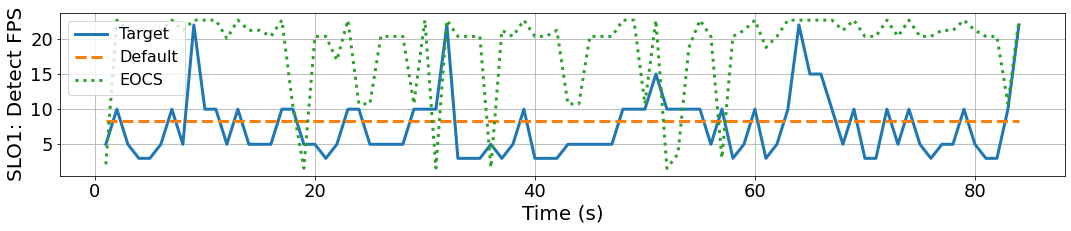

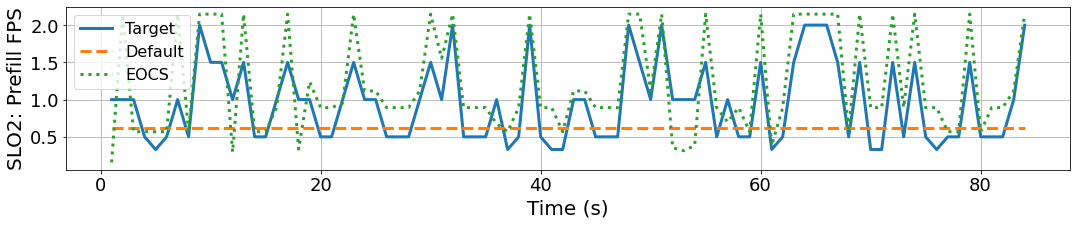

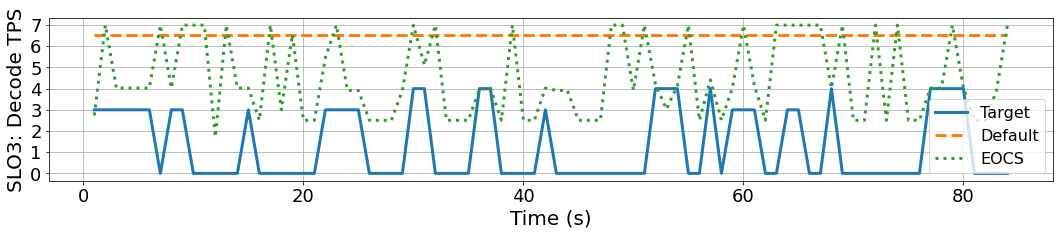

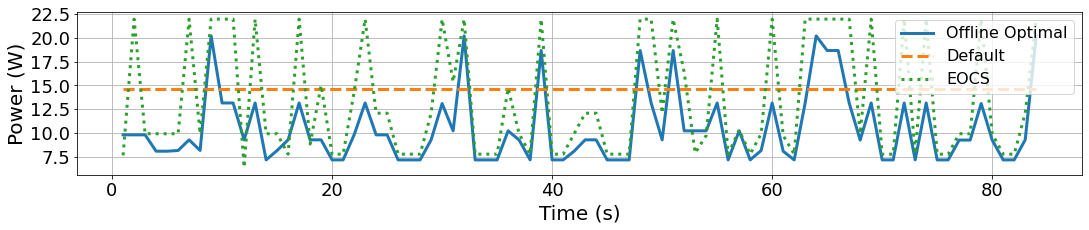

In [52]:
time = list(range(1, len(fps_od_required_list)+1))

fps_od_default_list = [fps_od_default for _ in range(len(fps_od_required_list))]
fps_p_default_list = [fps_p_default for _ in range(len(fps_od_required_list))]
tps_default_list = [tps_default for _ in range(len(fps_od_required_list))]
tps_power_default_list = [tps_power_default for _ in range(len(fps_od_required_list))]

plot_three_line(time, fps_od_required_list, fps_od_default_list, fps_od_selected_list, 'Time (s)', 'SLO1: Detect FPS', '', 'Target', 'Default', 'EOCS')
plot_three_line(time, fps_p_required_list, fps_p_default_list, fps_p_selected_list, 'Time (s)', 'SLO2: Prefill FPS', '', 'Target', 'Default', 'EOCS')
plot_three_line(time, tps_required_list, tps_default_list, tps_selected_list, 'Time (s)', 'SLO3: Decode TPS', '', 'Target', 'Default', 'EOCS')
plot_three_line(time, combined_power_best_list, tps_power_default_list, power_selected_list, 'Time (s)', 'Power (W)', '', 'Offline Optimal', 'Default', 'EOCS')

In [44]:
fps_od_miss_default_list = []
fps_od_miss_selected_list = []
fps_p_miss_default_list = []
fps_p_miss_selected_list = []
tps_miss_default_list = []
tps_miss_selected_list = []

for i in range(len(fps_od_required_list)):
    if fps_od_default_list[i] >= fps_od_required_list[i]:
        fps_od_miss_default_list.append(0)
    else:
        fps_od_miss_default_list.append(1)
    
    if fps_od_selected_list[i] >= fps_od_required_list[i]:
        fps_od_miss_selected_list.append(0)
    else:
        fps_od_miss_selected_list.append(1)

for i in range(len(fps_p_required_list)):
    if fps_p_default_list[i] >= fps_p_required_list[i]:
        fps_p_miss_default_list.append(0)
    else:
        fps_p_miss_default_list.append(1)
    
    if fps_p_selected_list[i] >= fps_p_required_list[i]:
        fps_p_miss_selected_list.append(0)
    else:
        fps_p_miss_selected_list.append(1)

for i in range(len(tps_required_list)):
    if tps_default_list[i] >= tps_required_list[i]:
        tps_miss_default_list.append(0)
    else:
        tps_miss_default_list.append(1)
    
    if tps_selected_list[i] >= tps_required_list[i]:
        tps_miss_selected_list.append(0)
    else:
        tps_miss_selected_list.append(1)

print(f"Average Optimal Power: {round(np.average(np.array(combined_power_best_list)), 2)}")
print(f"Average Default Power: {round(np.average(np.array(tps_power_default_list)), 2)}")
print(f"Average Selected Power: {round(np.average(np.array(power_selected_list)), 2)}")

print(f"Average SLO Miss (Detect, Default): {round(np.average(np.array(fps_od_miss_default_list)), 2)}")
print(f"Average SLO Miss (Detect, Selected): {round(np.average(np.array(fps_od_miss_selected_list)), 2)}")
print(f"Average SLO Miss (Prefill, Default): {round(np.average(np.array(fps_p_miss_default_list)), 2)}")
print(f"Average SLO Miss (Prefill, Selected): {round(np.average(np.array(fps_p_miss_selected_list)), 2)}")
print(f"Average SLO Miss (Decode, Default): {round(np.average(np.array(tps_miss_default_list)), 2)}")
print(f"Average SLO Miss (Decode, Selected): {round(np.average(np.array(tps_miss_selected_list)), 2)}")

Average Optimal Power: 10.42
Average Default Power: 14.6
Average Selected Power: 13.39
Average SLO Miss (Detect, Default): 0.43
Average SLO Miss (Detect, Selected): 0.08
Average SLO Miss (Prefill, Default): 0.55
Average SLO Miss (Prefill, Selected): 0.13
Average SLO Miss (Decode, Default): 0.0
Average SLO Miss (Decode, Selected): 0.04
